<a href="https://colab.research.google.com/github/bhadreshpsavani/LLMOPsNotes/blob/main/SummarizingLargerDocuments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pip install --upgrade --quiet tiktoken langchain langgraph langchain-community langchain_aws

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.0/115.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 5.2 MB/s eta 0:00:00


In [22]:
!pip uninstall transformers

Found existing installation: transformers 4.49.0
Uninstalling transformers-4.49.0:
  Would remove:
    /usr/local/bin/transformers-cli
    /usr/local/lib/python3.11/dist-packages/transformers-4.49.0.dist-info/*
    /usr/local/lib/python3.11/dist-packages/transformers/*
Proceed (Y/n)? Y
  Successfully uninstalled transformers-4.49.0


In [23]:
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 35.3 MB/s eta 0:00:00


In [1]:
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

In [2]:
from google.colab import userdata

In [3]:
import boto3
import os
# Initialize boto3 client with bedrock-runtime to access bedrock related feature
bedrock_client = boto3.client(
    'bedrock-runtime',
    region_name="us-east-1",
    aws_access_key_id=userdata.get('AWS_ACCESS_KEY_ID'),  # Retrieve from environment variables
    aws_secret_access_key=userdata.get('AWS_SECRET_ACCESS_KEY')
)

In [4]:

from langchain_aws import ChatBedrock
"""
specify Bedrock `model_id` by checking specific model if from below link
https://docs.aws.amazon.com/bedrock/latest/userguide/model-ids.html
Note: We will need to use `instruct` model as chat models

We can pass model paramers are dictionary object based on creativity we require
With Temparature 0, it will be less creative and 1 will be more creative
It will give crisp answer
"""
llm = ChatBedrock(
    model_id="mistral.mistral-7b-instruct-v0:2",
    model_kwargs=dict(temperature=0),
    client=bedrock_client,
)

# Stuff: summarize in a single LLM call

In [5]:
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains.llm import LLMChain
from langchain_core.prompts import ChatPromptTemplate

# Define prompt
prompt = ChatPromptTemplate.from_messages(
    [("system", "Write a concise summary of the following:\\n\\n{context}")]
)

# Instantiate chain
chain = create_stuff_documents_chain(llm, prompt)

# Invoke chain
result = chain.invoke({"context": docs})

In [6]:
result.strip()

'This article discusses the concept of building autonomous agents using large language models (LLMs) as their core controller. The potential applications of LLMs extend beyond generating well-written copies, stories, essays, and programs, as they can be framed as a powerful general problem solver. The article covers three main components of an LLM-powered autonomous agent system: planning, memory, and tool use.'

## Map-Reduce: summarize long texts via parallelization

In [7]:
from langchain_core.prompts import ChatPromptTemplate

map_prompt = ChatPromptTemplate.from_messages(
    [("system", "Write a concise summary of the following:\\n\\n{context}")]
)

In [8]:
reduce_template = """
The following is a set of summaries:
{docs}
Take these and distill it into a final, consolidated summary
of the main themes.
"""

reduce_prompt = ChatPromptTemplate([("human", reduce_template)])

In [9]:
from langchain_text_splitters import CharacterTextSplitter

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=0
)
split_docs = text_splitter.split_documents(docs)
print(f"Generated {len(split_docs)} documents.")

Generated 14 documents.


In [10]:
import operator
from typing import Annotated, List, Literal, TypedDict

from langchain.chains.combine_documents.reduce import (
    acollapse_docs,
    split_list_of_docs,
)
from langchain_core.documents import Document
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph

token_max = 1000


def length_function(documents: List[Document]) -> int:
    """Get number of tokens for input contents."""
    return sum(llm.get_num_tokens(doc.page_content) for doc in documents)


# This will be the overall state of the main graph.
# It will contain the input document contents, corresponding
# summaries, and a final summary.
class OverallState(TypedDict):
    # Notice here we use the operator.add
    # This is because we want combine all the summaries we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    contents: List[str]
    summaries: Annotated[list, operator.add]
    collapsed_summaries: List[Document]
    final_summary: str


# This will be the state of the node that we will "map" all
# documents to in order to generate summaries
class SummaryState(TypedDict):
    content: str


# Here we generate a summary, given a document
async def generate_summary(state: SummaryState):
    prompt = map_prompt.invoke(state["content"])
    response = await llm.ainvoke(prompt)
    return {"summaries": [response.content]}


# Here we define the logic to map out over the documents
# We will use this an edge in the graph
def map_summaries(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [
        Send("generate_summary", {"content": content}) for content in state["contents"]
    ]


def collect_summaries(state: OverallState):
    return {
        "collapsed_summaries": [Document(summary) for summary in state["summaries"]]
    }


async def _reduce(input: dict) -> str:
    prompt = reduce_prompt.invoke(input)
    response = await llm.ainvoke(prompt)
    return response.content


# Add node to collapse summaries
async def collapse_summaries(state: OverallState):
    doc_lists = split_list_of_docs(
        state["collapsed_summaries"], length_function, token_max
    )
    results = []
    for doc_list in doc_lists:
        results.append(await acollapse_docs(doc_list, _reduce))

    return {"collapsed_summaries": results}


# This represents a conditional edge in the graph that determines
# if we should collapse the summaries or not
def should_collapse(
    state: OverallState,
) -> Literal["collapse_summaries", "generate_final_summary"]:
    num_tokens = length_function(state["collapsed_summaries"])
    if num_tokens > token_max:
        return "collapse_summaries"
    else:
        return "generate_final_summary"


# Here we will generate the final summary
async def generate_final_summary(state: OverallState):
    response = await _reduce(state["collapsed_summaries"])
    return {"final_summary": response}


# Construct the graph
# Nodes:
graph = StateGraph(OverallState)
graph.add_node("generate_summary", generate_summary)  # same as before
graph.add_node("collect_summaries", collect_summaries)
graph.add_node("collapse_summaries", collapse_summaries)
graph.add_node("generate_final_summary", generate_final_summary)

# Edges:
graph.add_conditional_edges(START, map_summaries, ["generate_summary"])
graph.add_edge("generate_summary", "collect_summaries")
graph.add_conditional_edges("collect_summaries", should_collapse)
graph.add_conditional_edges("collapse_summaries", should_collapse)
graph.add_edge("generate_final_summary", END)

app = graph.compile()

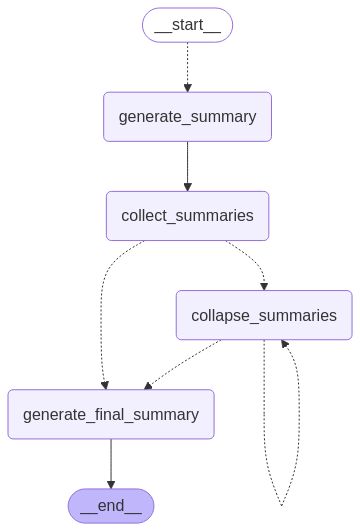

In [11]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [12]:
async for step in app.astream(
    {"contents": [doc.page_content for doc in split_docs]},
    {"recursion_limit": 20},
):
    print(list(step.keys()))

['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['collect_summaries']
['collapse_summaries']
['collapse_summaries']
['generate_final_summary']


In [13]:
print(step)

{'generate_final_summary': {'final_summary': " The summaries discuss the advancements in autonomous agents using Large Language Models (LLMs) as their core controller, with a focus on memory systems and efficient data processing techniques. The agent system consists of three main components: planning, memory, and tool use.\n\nPlanning involves breaking down complex tasks into smaller subgoals using techniques like Chain of Thought (CoT) and Tree of Thoughts (ToT). LLMs can decompose tasks with simple prompting, task-specific instructions, or human inputs. Another approach, LLM+P, relies on an external classical planner for long-horizon planning.\n\nSelf-reflection is crucial for autonomous agents to improve iteratively. ReAct integrates reasoning and acting within LLMs by extending the action space and using dynamic memory and self-reflection capabilities. Reflexion determines when trajectories are inefficient or contain hallucination and uses two-shot examples to guide future changes.

In [18]:
from pprint import pprint
pprint(step["generate_final_summary"]["final_summary"])

(' The summaries discuss the advancements in autonomous agents using Large '
 'Language Models (LLMs) as their core controller, with a focus on memory '
 'systems and efficient data processing techniques. The agent system consists '
 'of three main components: planning, memory, and tool use.\n'
 '\n'
 'Planning involves breaking down complex tasks into smaller subgoals using '
 'techniques like Chain of Thought (CoT) and Tree of Thoughts (ToT). LLMs can '
 'decompose tasks with simple prompting, task-specific instructions, or human '
 'inputs. Another approach, LLM+P, relies on an external classical planner for '
 'long-horizon planning.\n'
 '\n'
 'Self-reflection is crucial for autonomous agents to improve iteratively. '
 'ReAct integrates reasoning and acting within LLMs by extending the action '
 'space and using dynamic memory and self-reflection capabilities. Reflexion '
 'determines when trajectories are inefficient or contain hallucination and '
 'uses two-shot examples to guide